In [1]:
# Import libraries
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage collector

warnings.filterwarnings('ignore')

### Data Description
The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

### Data Exploration

In [2]:
# Reading feather format data(memory efficient) 
# Source: ttps://www.kaggle.com/datasets/munumbutt/amexfeather

train_raw = pd.read_feather('../input/amexfeather/train_data.ftr')

In [3]:
train_raw.head(15)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945801,0.001746,0.007866,1.004883,0.004219,0.110962,0.009857,0.009865,...,NaN,NaN,0.001925,0.008598,0.004528,NaN,0.000674,0.002222,0.002884,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940918,0.002182,0.018860,1.007812,0.004509,0.103333,0.006603,0.000783,...,NaN,NaN,0.001336,0.004360,0.009384,NaN,0.007729,0.007660,0.002224,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914551,0.003029,0.014328,1.000000,0.000263,0.108093,0.009529,0.007835,...,NaN,NaN,0.002398,0.008453,0.005554,NaN,0.001831,0.009613,0.007385,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950684,0.009895,0.016891,1.003906,0.001789,0.102783,0.002520,0.009819,...,NaN,NaN,0.009743,0.003967,0.007942,NaN,0.008720,0.004368,0.000996,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868652,0.001082,0.001930,1.007812,0.001772,0.100464,0.004627,0.006073,...,NaN,NaN,0.003611,0.009605,0.007267,NaN,0.008766,0.004753,0.009071,0


In [4]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 2.0+ GB


In [5]:
train_raw.shape

(5531451, 191)

In [6]:
# Number of unique customers in the dataset
train_raw["customer_ID"].nunique()

458913

In [7]:
# Date range
train_raw["S_2"].min(), train_raw["S_2"].max()

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [8]:
print("No. of features for each category:")
for pref in ["D_", "S_", "P_", "B_", "R_"]:
    print(f"{pref} : {len([i for i in train_raw.columns if i.startswith(pref)])}")


No. of features for each category:
D_ : 96
S_ : 22
P_ : 3
B_ : 40
R_ : 28


In [9]:
# Target values distribution
train_raw["target"].value_counts("%")

0    0.750903
1    0.249097
Name: target, dtype: float64

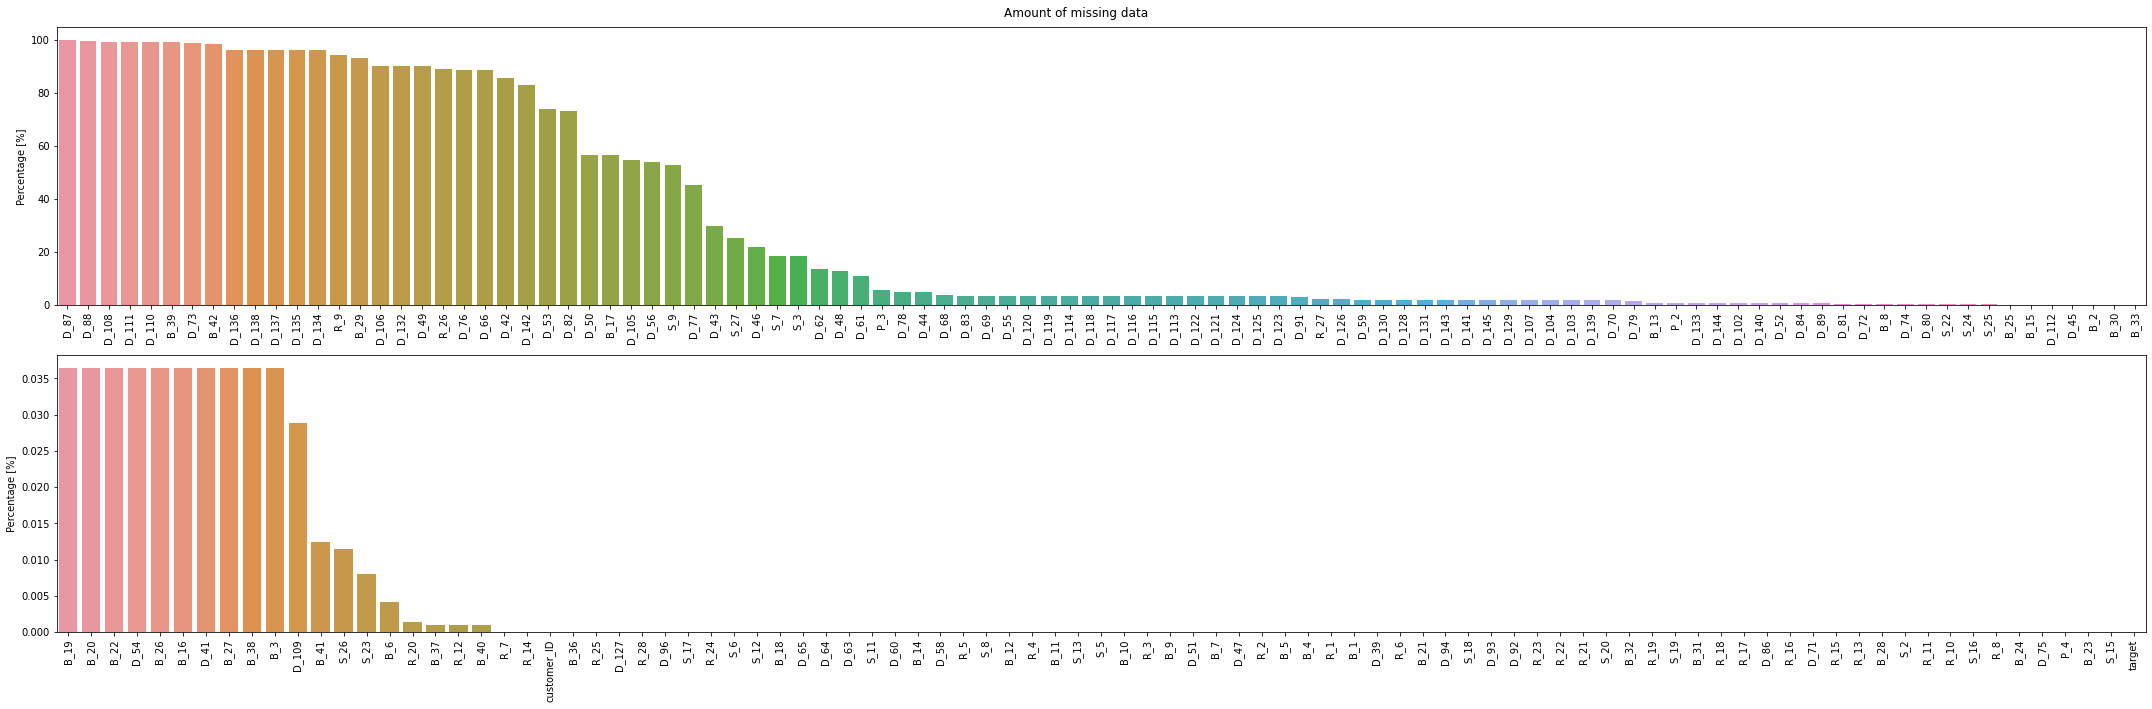

In [10]:
# Missing values
tmp = train_raw.isna().sum().mul(100).div(len(train_raw)).sort_values(ascending=False)

fig, ax = plt.subplots(2,1, figsize=(30,10))
sns.barplot(x=tmp[:100].index, y=tmp[:100].values, ax=ax[0])
sns.barplot(x=tmp[100:].index, y=tmp[100:].values, ax=ax[1])
ax[0].set_ylabel("Percentage [%]"), ax[1].set_ylabel("Percentage [%]")
ax[0].tick_params(axis='x', rotation=90); ax[1].tick_params(axis='x', rotation=90)
plt.suptitle("Amount of missing data")
plt.tight_layout()
plt.show()

In [11]:
missingDF = pd.DataFrame(tmp).reset_index()
missingDF[missingDF[0]>90]

,index,0
0,D_87,99.930127
1,D_88,99.891457
2,D_108,99.476846
3,D_111,99.433530
4,D_110,99.433530
5,B_39,99.391986
6,D_73,98.990211
7,B_42,98.707789
8,D_136,96.480146
9,D_138,96.480146


In [12]:
# columns with no missing values
len(missingDF[missingDF[0]==0])

70

In [13]:
# only 3 columns in payment(P_) category, checking missing data in them
train_raw[[i for i in train_raw.columns if i.startswith("P_")]].isna().sum().div(len(train_raw)).mul(100)

P_2    0.831337
P_3    5.450505
P_4    0.000000
dtype: float64

### Data Exploration for Two Customers with different "target" values(risk scores)

In [14]:
filtered_customer_data =train_raw[train_raw["customer_ID"].isin(['0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a', '00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5'])]

In [15]:
filtered_customer_data.head(1)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.00061,0.002674,0


In [16]:
filtered_customer_data.tail(1)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
25,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.00555,0.00507,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.00317,0.008514,0


In [17]:
filtered_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 12.3+ KB


In [18]:
# filtered_customer_data.describe()

In [19]:
# filtered_customer_data.isna().sum().mul(100).div(len(train_raw)).sort_values(ascending=False)[:5]

In [20]:
# excluding categorical and date features
plot_cols = [i for i in filtered_customer_data.columns if i not in ["target","customer_ID","S_2",'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]

In [21]:
len(plot_cols)

177

#### How each feature varies with time for both target values

<Figure size 432x288 with 0 Axes>

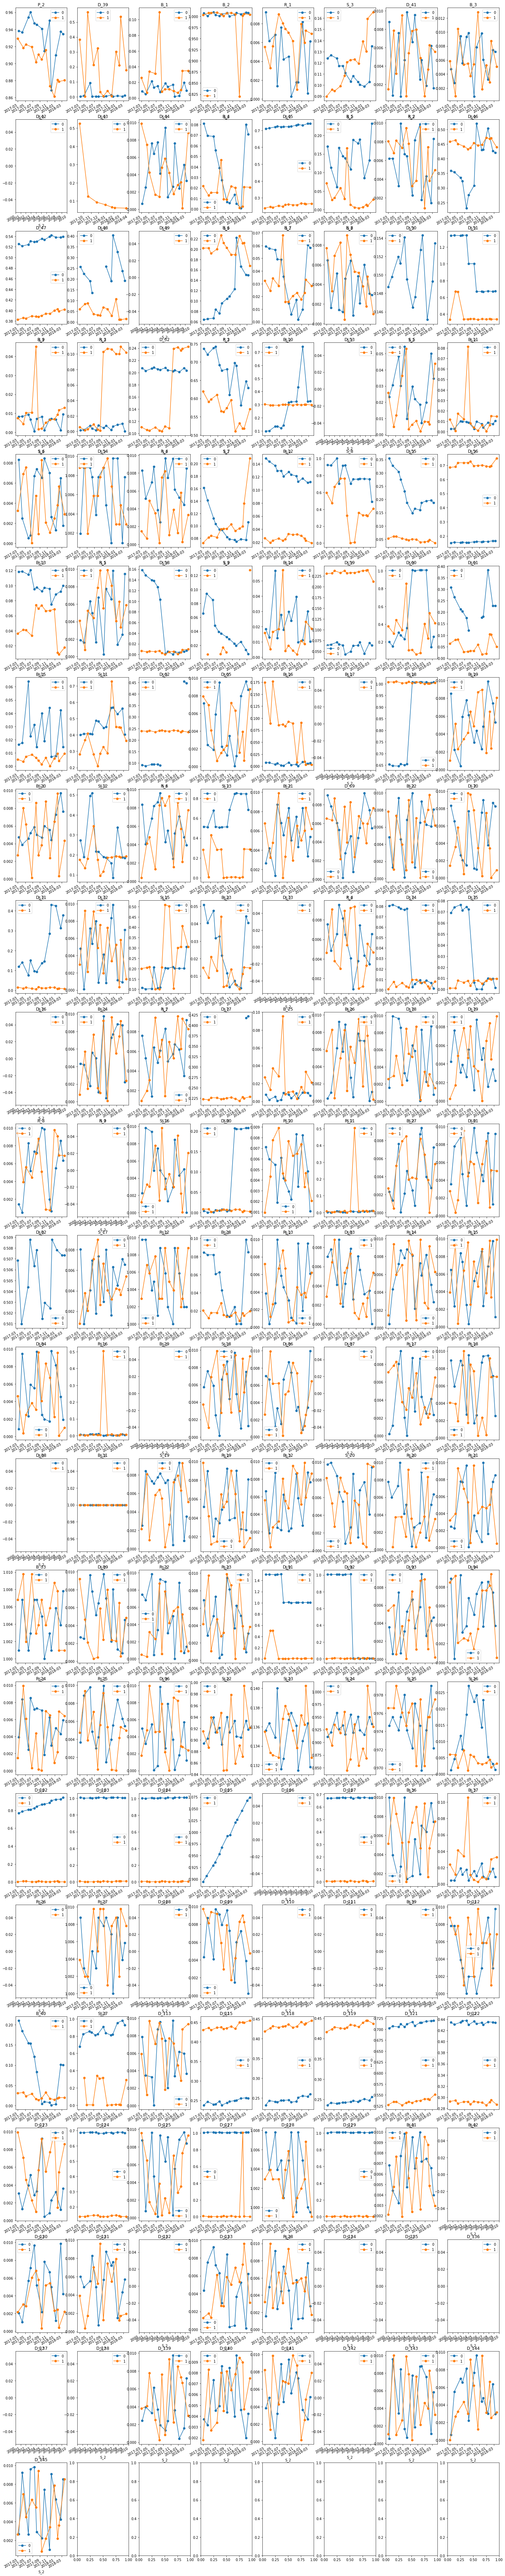

In [22]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig, axs = plt.subplots(23,8,figsize=(25, 150))
for i,ax in zip(plot_cols[:],axs.ravel()):
    filtered_customer_data.groupby("customer_ID").plot(x="S_2", y=i, marker="o", ax=ax)
    ax.legend(["0","1"])
    ax.set_title(i)


#### MORE EDA COMING SOON
# DO UPVOTE!